In [50]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

# Load model & Data

In [4]:
df = pd.read_csv('data/filtered.csv')
df = df.dropna()
df['label'] = df['label'].apply(lambda x: x.lower())

# Lets split our dataset
train_df, test_df = train_test_split(df, test_size=0.4, random_state=2021)

In [5]:
model = T5ForConditionalGeneration.from_pretrained('weights/t5')
model.to('cuda')
model.eval()

tokenizer = T5Tokenizer.from_pretrained('t5-small')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

# Prepare data for evaluation and inference

In [21]:
def one_hot_label(labels):
    return [1 if label == 'positive' else 0 for label in labels]

In [12]:
class T5Dataset(Dataset):
    def __init__(self, tokenizer, df, max_length=100):
        super(T5Dataset, self).__init__()
        
        self.tokenizer = tokenizer
        self.df = df
        self.max_length = max_length
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        input_text = self.df['text'].iloc[index]
        src_tokenized = self.tokenizer.encode_plus(
            input_text, 
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        
        input_ids = src_tokenized['input_ids'].squeeze()
        src_mask = src_tokenized['attention_mask'].squeeze()
    
        labels = self.df['label'].iloc[index]
        return {
            'input_ids': input_ids.long(),
            'src_mask': src_mask.long(),
            'label': labels
        }

In [13]:
eval_dataset = T5Dataset(tokenizer, test_df)
eval_sampler = SequentialSampler(eval_dataset)
eval_loader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=32)

In [26]:
y_true = []
y_pred = []
for eval_data in tqdm(eval_loader):
    inputs = eval_data['input_ids'].to('cuda')
    outputs = model.generate(inputs)
    decoded_outputs = tokenizer.batch_decode(outputs, clean_up_tokenization_spaces=True, skip_special_tokens=True)
    
    y_true.append(one_hot_label(eval_data['label']))
    y_pred.append(one_hot_label(decoded_outputs))

y_true = np.concatenate(y_true).astype(np.float32)
y_pred = np.concatenate(y_pred).astype(np.float32)

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85    319413
         1.0       0.86      0.83      0.85    319466

    accuracy                           0.85    638879
   macro avg       0.85      0.85      0.85    638879
weighted avg       0.85      0.85      0.85    638879

MCC: 0.7029659959714913


<AxesSubplot:>

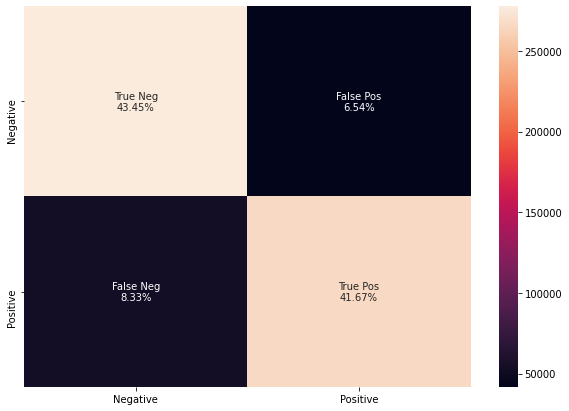

In [51]:
print(classification_report(y_true, y_pred))
print('MCC: {}'.format(matthews_corrcoef(y_true, y_pred)))
categories = ['Negative', 'Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']

plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_true, y_pred)
group_percentage = [
    '{0:.2%}'.format(value) for value in cm.ravel() / cm.sum()
]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentage)]

labels = np.array(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', xticklabels=categories, yticklabels=categories)

# Single Inference

In [59]:
batch_inputs = [
    'Life is great', 'No i dont think life is great', 
    'I hate my job', 'But i love my job', 'I wonder is life really that great, no i hate it'
]
inputs = tokenizer.batch_encode_plus(
    batch_inputs, max_length=100,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
outputs = model.generate(inputs['input_ids'].to('cuda'))
decoded_outputs = tokenizer.batch_decode(outputs, clean_up_tokenization_spaces=True, skip_special_tokens=True)
for index, output in enumerate(decoded_outputs):
    print('Input: {}, Sentiment: {}'.format(batch_inputs[index], output))

Input: Life is great, Sentiment: positive
Input: No i dont think life is great, Sentiment: negative
Input: I hate my job, Sentiment: negative
Input: But i love my job, Sentiment: positive
Input: I wonder is life really that great, no i hate it, Sentiment: negative
